## Adversary model
### 1: Find feasible combinations
Input: load, mf at load, temperature at load <br>
Output: supply, mf at supply and return, temperature at supply and return

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
from itertools import permutations
from math import factorial
from pyomo.environ import *

In [2]:
#Import import data handing functions
from import_data import *

In [14]:
#List of cities: Aakirkeby, Allinge, Gudhjem, Hasle, Klemensker, Nexo, Ostermarie, Ronne, Svaneke
city='Klemensker'
start_date='2023-02-01'
end_date='2023-03-01'
granularity='hourly' #daily or hourly
data = select_data(city, start_date, end_date, granularity)

c:\Users\junes\Desktop\BEOF\DP_codes\import_data.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[df["reading_datetime"] >= start_date][df["reading_datetime"] <= end_date]


In [15]:
data

,heat_meter_serial_number,city,reading_datetime,heat_meter_connection,hot_water_supply_temperature,hot_water_return_temperature,cumulative_heat_energy,cumulative_hot_water_volume,cumulative_supplied_energy_e8,cumulative_returned_energy_e9
1913255,78329292,Klemensker,2023-02-01 00:36:00,M-bus,68.230003,46.849998,273.769989,12937.139648,853244.0,612703.0
8349,78181804,Klemensker,2023-02-01 00:54:00,M-bus,70.980003,41.919998,190.199997,5603.319824,396575.0,229035.0
2444568,78329752,Klemensker,2023-02-01 00:56:00,M-bus,71.760002,45.450001,78.769997,2848.179932,201302.0,131923.0
223620,78181646,Klemensker,2023-02-01 00:58:00,M-bus,71.379997,33.080002,71.430000,1862.410034,131436.0,68487.0
2992547,78329751,Klemensker,2023-02-01 00:58:00,M-bus,66.959999,40.310001,111.769997,4024.429932,269622.0,171331.0
...,...,...,...,...,...,...,...,...,...,...
3455396,78181789,Klemensker,2023-02-28 23:59:00,M-bus,68.879997,42.380001,107.930000,3725.169922,253028.0,158116.0
3905202,78181707,Klemensker,2023-02-28 23:59:00,M-bus,71.279999,32.590000,119.860001,3061.939941,212966.0,107426.0
2061705,78083383,Klemensker,2023-02-28 23:59:00,M-bus,64.160004,43.799999,61.360001,3497.600098,216298.0,162482.0
1934332,78329742,Klemensker,2023-02-28 23:59:00,M-bus,67.379997,35.500000,112.260002,5115.160156,345339.0,246618.0


In [113]:
Klemensker_meters = data.heat_meter_serial_number.unique()

In [116]:
GISdata = pd.read_csv('Bornholm_meters.csv')

In [117]:
Klemensker_GISmeter_no = [i for i in range(0,len(GISdata.Vejadrnavn)) if isinstance(GISdata.Vejadrnavn[i], str) and "Klemensker" in GISdata.Vejadrnavn[i]] 

In [121]:
GISdata

,fid,G3E_ID,G3E_FNO,G3E_FID,G3E_CNO,G3E_CID,Feature,Afkoling,Bemærkning,Dato etable,...,Måler Nr.,Status kode,Tilstand,Timer,Forbrugsste,Maalernumme,Vejadrnavn,Forbrsthusn,Forbrstvejk,Forbrstside
0,1,67140,2005,16398002,20002,1,Forsyningspunkt Varme,NaN,BEM: ; ELM_TYPE: FORBRUGER; DYBDE: ; BELIGGENH...,NaN,...,NaN,Uoplyst,Uoplyst,NaN,1423791.0,78500057.0,Toftelunden,16.0,4521.0,NaN
1,2,67141,2005,16398003,20002,1,Forsyningspunkt Varme,NaN,BEM: ; ELM_TYPE: FORBRUGER; DYBDE: ; BELIGGENH...,NaN,...,NaN,Uoplyst,Uoplyst,NaN,1550443.0,6668878.0,Kuleborgvej,14.0,2238.0,NaN
2,3,67142,2005,16398004,20002,1,Forsyningspunkt Varme,NaN,BEM: ; ELM_TYPE: FORBRUGER; DYBDE: ; BELIGGENH...,NaN,...,NaN,Uoplyst,Uoplyst,NaN,1552053.0,6639252.0,Skovløkken (3720 Aakirkeby),4.0,3738.0,NaN
3,4,67143,2005,16398005,20002,1,Forsyningspunkt Varme,NaN,BEM: ; ELM_TYPE: FORBRUGER; DYBDE: ; BELIGGENH...,NaN,...,NaN,Uoplyst,Uoplyst,NaN,1552056.0,6668826.0,Tulipanvej,24.0,4599.0,NaN
4,5,67144,2005,16398006,20002,1,Forsyningspunkt Varme,NaN,BEM: ; ELM_TYPE: FORBRUGER; DYBDE: ; BELIGGENH...,NaN,...,NaN,Uoplyst,Uoplyst,NaN,1555523.0,78329374.0,Ellevej,8.0,903.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6559,6560,81937,2005,17190087,20002,1,Forsyningspunkt Varme,NaN,NaN,NaN,...,NaN,I drift,As Build,NaN,16903930.0,85061421.0,Brogade,8.0,441.0,NaN
6560,6561,81938,2005,17190088,20002,1,Forsyningspunkt Varme,NaN,NaN,NaN,...,NaN,I drift,As Build,NaN,16910120.0,85061430.0,Damgade,1.0,720.0,NaN
6561,6562,81939,2005,17190089,20002,1,Forsyningspunkt Varme,NaN,NaN,NaN,...,NaN,I drift,As Build,NaN,16905654.0,85061415.0,Turistvej,1.0,4602.0,NaN
6562,6563,81940,2005,17190090,20002,1,Forsyningspunkt Varme,NaN,NaN,NaN,...,NaN,I drift,As Build,NaN,16906163.0,85061460.0,Sdr. Strandvej,26.0,3570.0,NaN


In [ ]:

GIS_meters = GISdata[GISdata.]['Maalernumme']

In [115]:
len(Klemensker_GISmeter_no)

143

In [112]:
Klemensker_GISmeter_no = [i for i in range(0,len(GISdata.Vejadrnavn)) if "Klemensker" in GISdata.Vejadrnavn[i]] 

TypeError: argument of type 'float' is not iterable

In [110]:
sum(np.array(data.heat_meter_serial_number) == Klemensker_GISmeter_no[10])

0

In [101]:
data.heat_meter_serial_number == Klemensker_GISmeter_no[1]

1913255    False
8349       False
2444568    False
223620     False
2992547    False
           ...  
3455396    False
3905202    False
2061705    False
1934332    False
3460615    False
Name: heat_meter_serial_number, Length: 192600, dtype: bool

In [111]:
[i for i in range(len(Klemensker_GISmeter_no)) if sum(np.array(data.heat_meter_serial_number) == Klemensker_GISmeter_no[i]) > 0]

[]

In [91]:
np.array(data.heat_meter_serial_number)[0]

'78329292'

In [94]:
[i for i in range(len(data.heat_meter_serial_number)) if sum(np.array(data.heat_meter_serial_number)[0] == Klemensker_meters) == 0]

In [39]:
GISdata = pd.read_csv('Bornholm_meters.csv')
GIS_meters = GISdata[GISdata.]['Maalernumme']

In [40]:
GIS_meters

0       78500057.0
1        6668878.0
2        6639252.0
3        6668826.0
4       78329374.0
           ...    
6559    85061421.0
6560    85061430.0
6561    85061415.0
6562    85061460.0
6563    85061349.0
Name: Maalernumme, Length: 6564, dtype: float64

In [70]:
#load_data(data, number of meters (as range), number of days)
meter_data = load_data(data, range(0,5), 28)

c:\Users\junes\Desktop\BEOF\DP_codes\import_data.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_select_resample = df_select.resample('D', on='reading_datetime').mean()
c:\Users\junes\Desktop\BEOF\DP_codes\import_data.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_select_resample = df_select.resample('D', on='reading_datetime').mean()
c:\Users\junes\Desktop\BEOF\DP_codes\import_data.py:83: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which s

In [71]:
meter_data

{0: {'load': array([241.31, 241.48, 241.67, 241.85, 242.07, 242.28, 242.48, 242.67,
         242.86, 243.04, 243.21, 243.36, 243.51, 243.66, 243.82, 243.98,
         244.12, 244.26, 244.41, 244.58, 244.73, 244.88, 245.04, 245.21,
         245.36, 245.56, 245.76, 245.95], dtype=float32),
  'supply_temp': array([79.3 , 77.97, 84.81, 83.12, 85.66, 83.74, 84.43, 83.83, 84.77,
         80.71, 76.94, 82.07, 74.52, 76.74, 80.96, 82.29, 78.03, 73.12,
         81.4 , 80.31, 75.23, 81.22, 81.58, 77.09, 82.58, 84.08, 82.3 ,
         83.45], dtype=float32),
  'return_temp': array([39.89, 39.59, 43.93, 40.22, 43.38, 42.13, 42.55, 42.64, 42.43,
         40.51, 38.93, 41.82, 38.72, 39.72, 40.45, 42.73, 39.01, 37.6 ,
         41.03, 38.97, 38.61, 41.26, 41.1 , 38.87, 42.19, 40.48, 40.  ,
         43.83], dtype=float32),
  'cum_water_volume': array([6081.93, 6085.66, 6089.75, 6093.76, 6098.24, 6102.8 , 6106.88,
         6111.05, 6115.08, 6119.03, 6122.77, 6126.42, 6130.07, 6133.76,
         6137.33, 61

In [72]:
#Calculate coefficient
c_mean =[]
for d in range(0,5):
    c = []
    for i in range(0,28):
        l = meter_data[d]['load'][i] 
        r = meter_data[d]['cum_water_mass'][i] * (meter_data[d]['supply_temp'][i] - meter_data[d]['return_temp'][i])
        c.append(l/r)
    c_mean.append(np.mean(c))

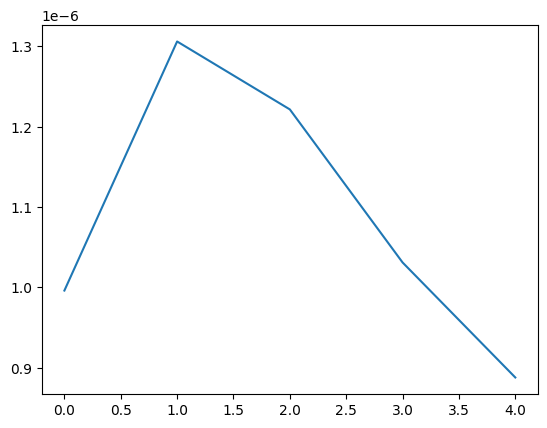

In [73]:
plt.plot(c_mean)

In [74]:
#This should be close to the specific heat capacity of water = 4181 J/kg/K
#1.16*10^-6 MWh/kg/K
np.mean(c_mean)

1.088438e-06

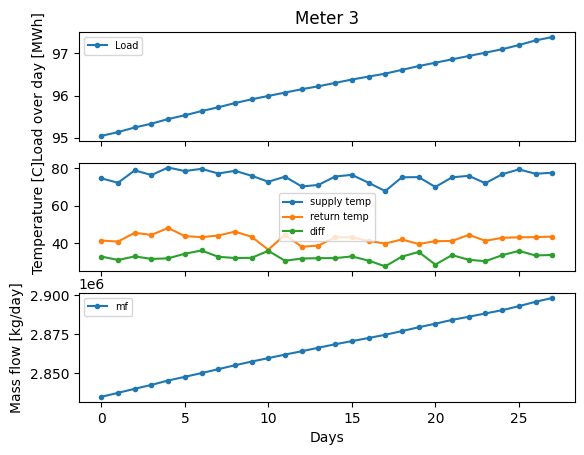

In [75]:
#Visualize input data
plot_meter_data(meter_data, 3, 28)

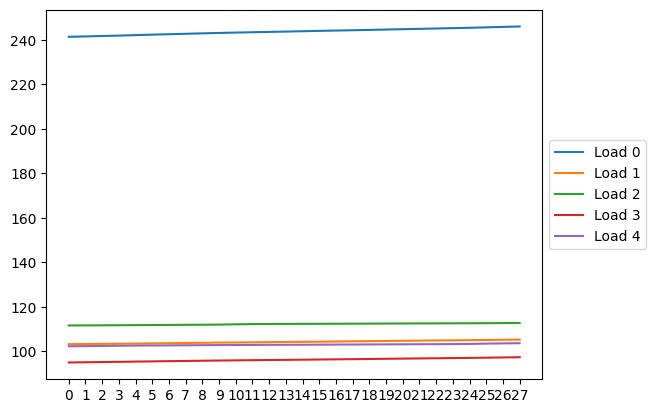

In [76]:
#Plot for heat load
for i in meter_data.keys():
    plt.plot(meter_data[i]['load'], label=f'Load {i}', color=f'C{i}')
    plt.xticks(np.arange(0,28,1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

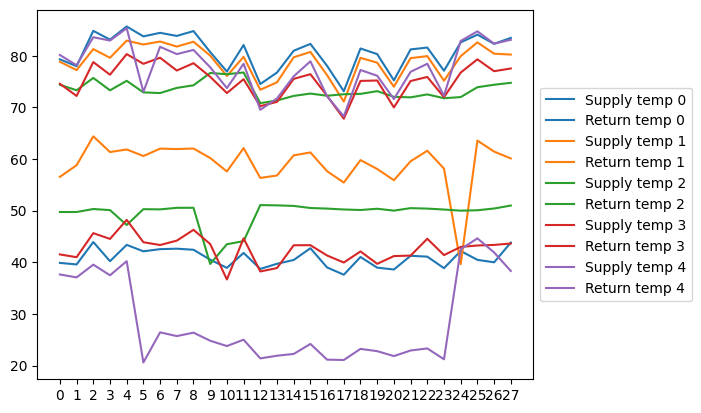

In [77]:
#Plot supply and return temperature
for i in meter_data.keys():
    plt.plot(meter_data[i]['supply_temp'], label=f'Supply temp {i}', color=f'C{i}')
    plt.plot(meter_data[i]['return_temp'], label=f'Return temp {i}', color=f'C{i}')
    plt.xticks(np.arange(0,28,1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [78]:
#Set parameters and sets
# T = np.arange(0,24,1) #Set of timesteps
max_flow = 10**8
T = [1]
N = [f'n{i}' for i in range(0,5)] #Set of nodes
P = [f'p{i}' for i in range(0,4)] #Set of pipelines
D = [f'd{i}' for i in range(0,5)] #Set of HES(demand)
HS = [f'hs{i}' for i in range(0,1)] #Set of HS(supply)
Pipe_S = {P[i]: {"nodeFrom": N[i], "nodeTo": N[i+1], "max_flow": max_flow} for i in range(0,4)} #Supply pipeline information
Pipe_R = {P[i]: {"nodeFrom": N[i+1], "nodeTo": N[i], "max_flow": max_flow} for i in range(0,4)} #Return pipeline information
Demand = {D[i]: {"node": N[i], "max_flow": max_flow, "mass_flow": meter_data[i]['cum_water_mass'][0],
                 "daily_consumption": meter_data[i]['load'][0]} for i in range(0,5)} #HES(demand) information
HS_loc = {HS[i]: {"node": N[i], "max_flow": max_flow} for i in range(0,1)} #HS(supply) information
Nodal_temp = {N[i]: {"supply_temp": meter_data[i]['supply_temp'][0], "return_temp": meter_data[i]['return_temp'][0]} for i in range(0,5)}
temp_diff = {N[i]: Nodal_temp[N[i]]["supply_temp"]-Nodal_temp[N[i]]["return_temp"] for i in range(0,5)}

# coeff = np.mean(c_mean) #coefficient of water 
coeff = 1.161389e-06
HS_cost = 10

In [79]:
#Create a new model
m_heat = gp.Model()

#Add variables
mf_S = m_heat.addVars(P, lb=0.0, name='mf_S')
mf_R = m_heat.addVars(P, lb=0.0, name='mf_R')
# mf_HES = m_heat.addVars(D, lb=0.0, name='mf_HES')
mf_HS = m_heat.addVars(HS, lb=0.0, name='mf_HS')
q_supply = m_heat.addVars(HS, lb=0.0, name='q_supply')
# demand = m_heat.addVars(D, lb=1.0, name='demand')
loss_up = m_heat.addVars(N, lb=0.0, name='heat_loss_up')
loss_down = m_heat.addVars(N, lb=0.0, name='heat_loss_down')


#Objective function
m_heat.setObjective(sum(HS_cost*q_supply[i] for i in HS) + sum(1000*(loss_up[n] - loss_down[n]) for n in N),GRB.MINIMIZE)

#Constraints
#MF bounds
m_heat.addConstrs((mf_S[p] <= Pipe_S[p]["max_flow"] for p in P), name = "mF_S upper bound")
m_heat.addConstrs((mf_R[p] <= Pipe_R[p]["max_flow"] for p in P), name = "mF_R upper bound")
# m_heat.addConstrs((mf_HES[d] <= Demand[d]["max_flow"] for d in D), name = "mF_HES upper bound")
m_heat.addConstrs((mf_HS[hs] <= HS_loc[hs]["max_flow"] for hs in HS), name = "mF_HS upper bound")
#Nodal balance (supply)
m_heat.addConstrs((sum(mf_S[p] for p in P if Pipe_S[p]["nodeTo"] == n) #=pipes ending at node n (reaching the node)=# 
                  + sum(mf_HS[hs] for hs in HS if HS_loc[hs]["node"] == n) #heat supply at node n
                  == sum(mf_S[p] for p in P if Pipe_S[p]["nodeFrom"] == n) #pipes starting at node n (leaving the node)
                  + sum(Demand[d]['mass_flow'] for d in D if Demand[d]["node"] == n) #demand at node n   
                  for n in N), name = "nodal_bal_supply")
#Nodal balance (return)
m_heat.addConstrs((sum(mf_R[p] for p in P if Pipe_R[p]["nodeFrom"] == n) #=pipes ending at node n (reaching the node)=# 
                  + sum(mf_HS[hs] for hs in HS if HS_loc[hs]["node"] == n) #heat supply at node n
                  == sum(mf_R[p] for p in P if Pipe_R[p]["nodeTo"] == n) #pipes starting at node n (leaving the node)
                  + sum(Demand[d]['mass_flow'] for d in D if Demand[d]["node"] == n) #demand at node n   
                  for n in N), name = "nodal_bal_return")

#Load definition
m_heat.addConstrs((sum(Demand[d]["daily_consumption"] for d in D if Demand[d]["node"] == n) + loss_up[n] - loss_down[n]
                  == coeff*sum(Demand[d]['mass_flow'] for d in D if Demand[d]["node"] == n)*temp_diff[n]
                  for n in N), name = "demand def")
#Supply definition
m_heat.addConstrs((gp.quicksum(q_supply[hs] for hs in HS if HS_loc[hs]["node"] == n) 
                  == coeff*sum(mf_HS[hs] for hs in HS if HS_loc[hs]["node"] == n)*temp_diff[n]
                  for n in N), name = "supply def")

# Optimize model
m_heat.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 29 rows, 20 columns and 39 nonzeros
Model fingerprint: 0x16f17019
Coefficient statistics:
  Matrix range     [5e-05, 1e+00]
  Objective range  [1e+01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+08]
Presolve removed 29 rows and 20 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.6134417e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.613441655e+04


In [80]:
#Print the model in a readable format to check constraints
#m_heat.write("heat_flow_model.lp")

In [81]:
for v in m_heat.getVars():
    print(v.varName, v.x)

mf_S[p0] 13173850.0
mf_S[p1] 9088140.0
mf_S[p2] 5204410.0
mf_S[p3] 2369800.0
mf_R[p0] 13173850.0
mf_R[p1] 9088140.0
mf_R[p2] 5204410.0
mf_R[p3] 2369800.0
mf_HS[hs0] 19255780.0
q_supply[hs0] 881.343688897936
heat_loss_up[n0] 37.062035245012396
heat_loss_up[n1] 2.460808121040813
heat_loss_up[n2] 0.0
heat_loss_up[n3] 13.730486311967965
heat_loss_up[n4] 14.633509183923309
heat_loss_down[n0] 0.0
heat_loss_down[n1] 0.0
heat_loss_down[n2] 0.5658592014617625
heat_loss_down[n3] 0.0
heat_loss_down[n4] 0.0


In [82]:
demand_set = [Demand[d]['daily_consumption'] for d in D]
demand_set

[241.31, 103.26, 111.66, 95.04, 102.31]

In [83]:
temp_diff

{'n0': 39.410004,
 'n1': 22.280003,
 'n2': 24.630001,
 'n3': 33.04,
 'n4': 42.489998}

In [84]:
Permutations = [f'perm{i}' for i in range(0,factorial(len(D)))] #Set of permutations
D_perm = {Permutations[i]: {D[j]: list(permutations(N))[i][j] for j in range(0,len(D))} for i in range(0,factorial(len(D)))}
T_diff_perm = {Permutations[i]: {N[j]: list(permutations(temp_diff.values()))[i][j] for j in range(0,len(N))} for i in range(0,factorial(len(N)))}
# D_perm

In [85]:
D_perm

{'perm0': {'d0': 'n0', 'd1': 'n1', 'd2': 'n2', 'd3': 'n3', 'd4': 'n4'},
 'perm1': {'d0': 'n0', 'd1': 'n1', 'd2': 'n2', 'd3': 'n4', 'd4': 'n3'},
 'perm2': {'d0': 'n0', 'd1': 'n1', 'd2': 'n3', 'd3': 'n2', 'd4': 'n4'},
 'perm3': {'d0': 'n0', 'd1': 'n1', 'd2': 'n3', 'd3': 'n4', 'd4': 'n2'},
 'perm4': {'d0': 'n0', 'd1': 'n1', 'd2': 'n4', 'd3': 'n2', 'd4': 'n3'},
 'perm5': {'d0': 'n0', 'd1': 'n1', 'd2': 'n4', 'd3': 'n3', 'd4': 'n2'},
 'perm6': {'d0': 'n0', 'd1': 'n2', 'd2': 'n1', 'd3': 'n3', 'd4': 'n4'},
 'perm7': {'d0': 'n0', 'd1': 'n2', 'd2': 'n1', 'd3': 'n4', 'd4': 'n3'},
 'perm8': {'d0': 'n0', 'd1': 'n2', 'd2': 'n3', 'd3': 'n1', 'd4': 'n4'},
 'perm9': {'d0': 'n0', 'd1': 'n2', 'd2': 'n3', 'd3': 'n4', 'd4': 'n1'},
 'perm10': {'d0': 'n0', 'd1': 'n2', 'd2': 'n4', 'd3': 'n1', 'd4': 'n3'},
 'perm11': {'d0': 'n0', 'd1': 'n2', 'd2': 'n4', 'd3': 'n3', 'd4': 'n1'},
 'perm12': {'d0': 'n0', 'd1': 'n3', 'd2': 'n1', 'd3': 'n2', 'd4': 'n4'},
 'perm13': {'d0': 'n0', 'd1': 'n3', 'd2': 'n1', 'd3': 'n4', '

In [86]:
T_diff_perm

{'perm0': {'n0': 39.410004,
  'n1': 22.280003,
  'n2': 24.630001,
  'n3': 33.04,
  'n4': 42.489998},
 'perm1': {'n0': 39.410004,
  'n1': 22.280003,
  'n2': 24.630001,
  'n3': 42.489998,
  'n4': 33.04},
 'perm2': {'n0': 39.410004,
  'n1': 22.280003,
  'n2': 33.04,
  'n3': 24.630001,
  'n4': 42.489998},
 'perm3': {'n0': 39.410004,
  'n1': 22.280003,
  'n2': 33.04,
  'n3': 42.489998,
  'n4': 24.630001},
 'perm4': {'n0': 39.410004,
  'n1': 22.280003,
  'n2': 42.489998,
  'n3': 24.630001,
  'n4': 33.04},
 'perm5': {'n0': 39.410004,
  'n1': 22.280003,
  'n2': 42.489998,
  'n3': 33.04,
  'n4': 24.630001},
 'perm6': {'n0': 39.410004,
  'n1': 24.630001,
  'n2': 22.280003,
  'n3': 33.04,
  'n4': 42.489998},
 'perm7': {'n0': 39.410004,
  'n1': 24.630001,
  'n2': 22.280003,
  'n3': 42.489998,
  'n4': 33.04},
 'perm8': {'n0': 39.410004,
  'n1': 24.630001,
  'n2': 33.04,
  'n3': 22.280003,
  'n4': 42.489998},
 'perm9': {'n0': 39.410004,
  'n1': 24.630001,
  'n2': 33.04,
  'n3': 42.489998,
  'n4': 22

In [87]:
model_input = {
    'N': N,
    'P': P,
    'HS': HS,
    'HS_cost': HS_cost,
    'Pipe_S': Pipe_S,
    'Pipe_R': Pipe_R,
    'Demand': Demand,
    'HS_loc': HS_loc,
    'temp_diff': temp_diff,
    'coeff': coeff
}

In [88]:
def feasible_combinations(model_input, D_perm, T_diff_perm, permutation):
    #Input
    N = model_input['N']
    P = model_input['P']
    HS = model_input['HS']
    HS_cost = model_input['HS_cost']
    Pipe_S = model_input['Pipe_S']
    Pipe_R = model_input['Pipe_R']
    Demand = model_input['Demand']
    HS_loc = model_input['HS_loc']
    temp_diff = model_input['temp_diff']
    coeff = model_input['coeff']

    #Create a new model
    m = gp.Model()

    #Add variables
    mf_S = m.addVars(P, lb=0.0, name='mf_S')
    mf_R = m.addVars(P, lb=0.0, name='mf_R')
    # mf_HES = m_heat.addVars(D, lb=0.0, name='mf_HES')
    mf_HS = m.addVars(HS, lb=0.0, name='mf_HS')
    q_supply = m.addVars(HS, lb=0.0, name='q_supply')
    # demand = m_heat.addVars(D, lb=1.0, name='demand')
    loss_up = m.addVars(N, lb=0.0, name='heat_loss_up')
    loss_down = m.addVars(N, lb=0.0, name='heat_loss_down')

    #Objective function
    m.setObjective(sum(HS_cost*q_supply[i] for i in HS) + sum(1000*(loss_up[n] + loss_down[n]) for n in N), GRB.MINIMIZE)

    #Constraints
    #MF bounds
    m.addConstrs((mf_S[p] <= Pipe_S[p]["max_flow"] for p in P), name = "mF_S upper bound")
    m.addConstrs((mf_R[p] <= Pipe_R[p]["max_flow"] for p in P), name = "mF_R upper bound")
    # m_heat.addConstrs((mf_HES[d] <= Demand[d]["max_flow"] for d in D), name = "mF_HES upper bound")
    m.addConstrs((mf_HS[hs] <= HS_loc[hs]["max_flow"] for hs in HS), name = "mF_HS upper bound")
    #Nodal balance (supply)
    m.addConstrs((sum(mf_S[p] for p in P if Pipe_S[p]["nodeTo"] == n) #=pipes ending at node n (reaching the node)=# 
                    + sum(mf_HS[hs] for hs in HS if HS_loc[hs]["node"] == n) #heat supply at node n
                    == sum(mf_S[p] for p in P if Pipe_S[p]["nodeFrom"] == n) #pipes starting at node n (leaving the node)
                    + sum(Demand[d]['mass_flow'] for d in D if D_perm[d] == n) #demand at node n   
                    for n in N), name = "nodal_bal_supply")
    #Nodal balance (return)
    m.addConstrs((sum(mf_R[p] for p in P if Pipe_R[p]["nodeFrom"] == n) #=pipes ending at node n (reaching the node)=# 
                    + sum(mf_HS[hs] for hs in HS if HS_loc[hs]["node"] == n) #heat supply at node n
                    == sum(mf_R[p] for p in P if Pipe_R[p]["nodeTo"] == n) #pipes starting at node n (leaving the node)
                    + sum(Demand[d]['mass_flow'] for d in D if D_perm[d] == n) #demand at node n   
                    for n in N), name = "nodal_bal_return")

    #Load definition
    m.addConstrs((sum(Demand[d]["daily_consumption"] for d in D if D_perm[d] == n) + loss_up[n] - loss_down[n]
                    == coeff*sum(Demand[d]['mass_flow'] for d in D if D_perm[d] == n)*T_diff_perm[n]
                    for n in N), name = "demand def")
    #Supply definition
    m.addConstrs((gp.quicksum(q_supply[hs] for hs in HS if HS_loc[hs]["node"] == n) 
                    == coeff*sum(mf_HS[hs] for hs in HS if HS_loc[hs]["node"] == n)*T_diff_perm[n]
                    for n in N), name = "supply def")

    # Optimize model
    m.optimize()

    if m.status == 3: #Infeasible
        print('Model infeasible!')
        m_result = {'obj': 'infeasible',
                    'permutation': permutation}

    elif m.status == 2: #Feasible
        print('Model feasible!')
        m_result = {'obj': m.ObjVal,
                    'permutation': permutation,
                    'mf_S': {p: mf_S[p].x for p in P},
                    'mf_R': {p: mf_R[p].x for p in P},
                    'mf_HS': {hs: mf_HS[hs].x for hs in HS},
                    'q_supply': {hs: q_supply[hs].x for hs in HS},
                    'loss_up': {n: loss_up[n].x for n in N},
                    'loss_down': {n: loss_down[n].x for n in N}}

        return m_result
    

In [89]:
m_result = {}
for perm in Permutations:
    m_result[perm] = feasible_combinations(model_input, D_perm[perm], T_diff_perm[perm], perm)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 29 rows, 20 columns and 39 nonzeros
Model fingerprint: 0x975214e4
Coefficient statistics:
  Matrix range     [5e-05, 1e+00]
  Objective range  [1e+01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+08]
Presolve removed 29 rows and 20 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7266135e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.726613495e+04
Model feasible!
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 l

In [90]:
for perm in Permutations:
    if m_result[perm]['obj'] == 'infeasible':
        print(m_result[perm]['permutation'])

In [91]:
sum([m_result[perm]['obj'] == 'infeasible' for perm in Permutations])

0

### 2: For feasible combinations, find the Optimal heat flow from operator's perspective

Input: supply, mf at supply and return, temperature at supply and return <br>
Output: load, mf at load, temperature at load (with warm start)

In [97]:
OHF_input = {
    'N': N,
    'P': P,
    'HS': HS,
    'D': D,
    'HS_cost': HS_cost,
    'Pipe_S': Pipe_S,
    'Pipe_R': Pipe_R,
    'Demand': Demand,
    'HS_loc': HS_loc,
    'coeff': coeff
}

In [98]:
load_perm = {Permutations[i]: {D[j]: list(permutations([Demand[d]["daily_consumption"] for d in D]))[i][j] for j in range(0,len(D))} for i in range(0,factorial(len(D)))}
mf_HES_perm = {Permutations[i]: {D[j]: list(permutations([Demand[d]['mass_flow'] for d in D]))[i][j] for j in range(0,len(D))} for i in range(0,factorial(len(D)))}

In [95]:
def OHF(OHF_input, m_result, D_perm, T_diff_perm, mf_HES_perm, load_perm):
    #Input
    N = OHF_input['N']
    P = OHF_input['P']
    HS = OHF_input['HS']
    D = OHF_input['D']
    HS_cost = OHF_input['HS_cost']
    Pipe_S = OHF_input['Pipe_S']
    Pipe_R = OHF_input['Pipe_R']
    Demand = OHF_input['Demand']
    HS_loc = OHF_input['HS_loc']
    coeff = OHF_input['coeff']

    # Create a concrete Pyomo model
    OHF = ConcreteModel()

    # Define the indexes
    OHF.N = RangeSet(0, len(N)-1)
    OHF.P = RangeSet(0, len(P)-1)
    OHF.HS = RangeSet(0, len(HS)-1)
    OHF.D = RangeSet(0, len(D)-1)
    # OHF.N = RangeSet(0, 4)
    # OHF.P = RangeSet(0, 3)
    # OHF.HS = RangeSet(0)
    # OHF.D = RangeSet(0, 4)

    # Define the decision variables
    OHF.q_supply = Var(OHF.HS, within=NonNegativeReals)
    OHF.mf_HES = Var(OHF.D, within=NonNegativeReals)
    OHF.demand = Var(OHF.D, within=NonNegativeReals)
    OHF.temp_diff = Var(OHF.N, within=NonNegativeReals)

    # Define the objective function
    OHF.obj = Objective(expr=sum(HS_cost*OHF.q_supply[hs] for hs in OHF.HS))

    # Constraints
    #MF bounds
    OHF.mf_HES_lim = ConstraintList()
    for d in OHF.D:
        OHF.mf_HES_lim.add(OHF.mf_HES[d] <= Demand[D[d]]["max_flow"])

    OHF.nodal_bal_supply = ConstraintList()
    OHF.nodal_bal_return = ConstraintList()
    OHF.load_def = ConstraintList()
    OHF.supply_def = ConstraintList()
    for n in OHF.N:
        #Nodal balance (supply)
        OHF.nodal_bal_supply.add(sum(m_result['mf_S'][P[p]] for p in OHF.P if Pipe_S[P[p]]["nodeTo"] == N[n]) 
                                + sum(m_result['mf_HS'][HS[hs]] for hs in OHF.HS if HS_loc[HS[hs]]["node"] == N[n]) 
                                == sum(m_result['mf_S'][P[p]] for p in OHF.P if Pipe_S[P[p]]["nodeFrom"] == N[n]) 
                                + sum(OHF.mf_HES[d] for d in OHF.D if D_perm[D[d]] == N[n]))
        #Nodal balance (return)
        OHF.nodal_bal_return.add(sum(m_result['mf_R'][P[p]] for p in OHF.P if Pipe_R[P[p]]["nodeFrom"] == N[n]) 
                                + sum(m_result['mf_HS'][HS[hs]] for hs in OHF.HS if HS_loc[HS[hs]]["node"] == N[n]) 
                                == sum(m_result['mf_R'][P[p]] for p in OHF.P if Pipe_R[P[p]]["nodeTo"] == N[n]) 
                                + sum(OHF.mf_HES[d] for d in OHF.D if D_perm[D[d]] == N[n]))
        #Load definition
        OHF.load_def.add(sum(OHF.demand[d] for d in OHF.D if D_perm[D[d]] == N[n])
                        == coeff*sum(OHF.mf_HES[d] for d in OHF.D if D_perm[D[d]] == N[n])
                        *OHF.temp_diff[n])
        #Supply definition
        OHF.supply_def.add(sum(OHF.q_supply[hs] for hs in OHF.HS if HS_loc[HS[hs]]["node"] == N[n]) 
                            == coeff*sum(m_result['mf_HS'][HS[hs]] for hs in OHF.HS if HS_loc[HS[hs]]["node"] == N[n])
                            *OHF.temp_diff[n])

    # def supply_def_constraint_rule(OHF, n):
    #     return sum(OHF.q_supply[hs] for hs in OHF.HS if HS_loc[HS[hs]]["node"] == N[n]) \
    #         == coeff * sum(m_result['mf_HS'][HS[hs]] for hs in OHF.HS if HS_loc[HS[hs]]["node"] == N[n]) * OHF.temp_diff[n]


    # OHF.supply_def_constraint = Constraint(OHF.N, rule=supply_def_constraint_rule)


    # Define the Ipopt solver with warm start on the variables
    solver = SolverFactory('ipopt')
    solver.options['warm_start_init_point'] = 'yes'

    # Set the initial values for the decision variables
    for hs in OHF.HS:
        OHF.q_supply[hs].value = m_result['q_supply'][HS[hs]]
    for d in OHF.D:
        OHF.mf_HES[d].value = mf_HES_perm[D[d]]
        OHF.demand[d].value = load_perm[D[d]]
    for n in OHF.N:
        OHF.temp_diff[n].value = T_diff_perm[N[n]]

    # Solve the optimization problem
    result = solver.solve(OHF)
    
    return result


In [29]:
m_result['perm0']['q_supply'][HS[0]]

881.343688897936

In [111]:
m_result['perm0']

{'obj': 77266.1349523856,
 'permutation': 'perm0',
 'mf_S': {'p0': 13173850.0, 'p1': 9088140.0, 'p2': 5204410.0, 'p3': 2369800.0},
 'mf_R': {'p0': 13173850.0, 'p1': 9088140.0, 'p2': 5204410.0, 'p3': 2369800.0},
 'mf_HS': {'hs0': 19255780.0},
 'q_supply': {'hs0': 881.343688897936},
 'loss_up': {'n0': 37.062035245012396,
  'n1': 2.460808121040813,
  'n2': 0.0,
  'n3': 13.730486311967965,
  'n4': 14.633509183923309},
 'loss_down': {'n0': 0.0,
  'n1': 0.0,
  'n2': 0.5658592014617625,
  'n3': 0.0,
  'n4': 0.0}}

In [115]:
m_result1 = m_result['perm0']
D_perm1 = D_perm['perm0']
T_diff_perm1 = T_diff_perm['perm0']
mf_HES_perm1 = mf_HES_perm['perm0']
load_perm1 = load_perm['perm0']

#Input
HS_cost = OHF_input['HS_cost']
Pipe_S = OHF_input['Pipe_S']
Pipe_R = OHF_input['Pipe_R']
Demand = OHF_input['Demand']
HS_loc = OHF_input['HS_loc']
coeff = OHF_input['coeff']

# Create a concrete Pyomo model
OHF = ConcreteModel()

# Define the indexes
OHF.N = RangeSet(0, len(N)-1)
OHF.P = RangeSet(0, len(P)-1)
# OHF.HS = Set(initialize=range(0,1))
OHF.HS = RangeSet(0, len(HS)-1)
OHF.D = RangeSet(0, len(D)-1)

# Define the decision variables
# OHF.q_supply = Var(within=NonNegativeReals)
OHF.mf_HES = Var(OHF.D, within=NonNegativeReals)
OHF.demand = Var(OHF.D, within=NonNegativeReals)
OHF.temp_diff = Var(OHF.N, within=NonNegativeReals)
OHF.loss_up = Var(OHF.N, within=NonNegativeReals)
OHF.loss_down = Var(OHF.N, within=NonNegativeReals)

# Define the objective function
OHF.obj = Objective(expr=sum(1000*(OHF.loss_up[n] + OHF.loss_down[n]) for n in OHF.N))

# Constraints
#MF bounds
OHF.mf_HES_lim = ConstraintList()
for d in OHF.D:
    OHF.mf_HES_lim.add(OHF.mf_HES[d] <= Demand[D[d]]["max_flow"])

OHF.nodal_bal_supply = ConstraintList()
OHF.nodal_bal_return = ConstraintList()
OHF.load_def = ConstraintList()
OHF.supply_def = ConstraintList()
for n in OHF.N:
    #Nodal balance (supply)
    OHF.nodal_bal_supply.add(sum(m_result1['mf_S'][P[p]] for p in OHF.P if Pipe_S[P[p]]["nodeTo"] == N[n]) 
                            + sum(m_result1['mf_HS'][HS[hs]] for hs in OHF.HS if HS_loc[HS[hs]]["node"] == N[n]) 
                            == sum(m_result1['mf_S'][P[p]] for p in OHF.P if Pipe_S[P[p]]["nodeFrom"] == N[n]) 
                            + sum(OHF.mf_HES[d] for d in OHF.D if D_perm1[D[d]] == N[n]))
    #Nodal balance (return)
    OHF.nodal_bal_return.add(sum(m_result1['mf_R'][P[p]] for p in OHF.P if Pipe_R[P[p]]["nodeFrom"] == N[n]) 
                            + sum(m_result1['mf_HS'][HS[hs]] for hs in OHF.HS if HS_loc[HS[hs]]["node"] == N[n]) 
                            == sum(m_result1['mf_R'][P[p]] for p in OHF.P if Pipe_R[P[p]]["nodeTo"] == N[n]) 
                            + sum(OHF.mf_HES[d] for d in OHF.D if D_perm1[D[d]] == N[n]))
    #Load definition
    OHF.load_def.add(sum(OHF.demand[d] for d in OHF.D if D_perm1[D[d]] == N[n])
                    == coeff*sum(OHF.mf_HES[d] for d in OHF.D if D_perm1[D[d]] == N[n])
                    *OHF.temp_diff[n])
    #Supply definition
    OHF.supply_def.add(sum(m_result1['q_supply'][HS[hs]] for hs in OHF.HS if HS_loc[HS[hs]]["node"] == N[n]) 
                        + OHF.loss_up[n] - OHF.loss_down[n]
                        == coeff*sum(m_result1['mf_HS'][HS[hs]] for hs in OHF.HS if HS_loc[HS[hs]]["node"] == N[n])
                        *OHF.temp_diff[n]
                        )



In [116]:
OHF.pprint()

5 Set Declarations
    load_def_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    mf_HES_lim_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    nodal_bal_return_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    nodal_bal_supply_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    supply_def_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}

4 RangeSet Declarations
    D : Dimen=1, Size=5, Bounds=(0, 4)
        Key  : Finite : Members
        None :   True :   [0:4]
    HS : Dimen=1, Size=1, Bo

In [109]:
m_result1 = m_result['perm0']
D_perm1 = D_perm['perm0']
T_diff_perm1 = T_diff_perm['perm0']
mf_HES_perm1 = mf_HES_perm['perm0']
load_perm1 = load_perm['perm0']

#Input
HS_cost = OHF_input['HS_cost']
Pipe_S = OHF_input['Pipe_S']
Pipe_R = OHF_input['Pipe_R']
Demand = OHF_input['Demand']
HS_loc = OHF_input['HS_loc']
coeff = OHF_input['coeff']

# Create a concrete Pyomo model
OHF = ConcreteModel()

# Define the indexes
OHF.N = RangeSet(0, len(N)-1)
OHF.P = RangeSet(0, len(P)-1)
# OHF.HS = Set(initialize=range(0,1))
OHF.HS = RangeSet(0, len(HS)-1)
OHF.D = RangeSet(0, len(D)-1)

# Define the decision variables
# OHF.q_supply = Var(within=NonNegativeReals)
OHF.mf_HES = Var(OHF.D, within=NonNegativeReals)
OHF.demand = Var(OHF.D, within=NonNegativeReals)
OHF.temp_diff = Var(OHF.N, within=NonNegativeReals)
OHF.loss_up = Var(OHF.N, within=NonNegativeReals)
OHF.loss_down = Var(OHF.N, within=NonNegativeReals)


# Define the objective function
OHF.obj = Objective(expr=sum(1000*(OHF.loss_up[n] + OHF.loss_down[n]) for n in OHF.N))

# Constraints
#MF bounds
OHF.mf_HES_lim = ConstraintList()
for d in OHF.D:
    OHF.mf_HES_lim.add(OHF.mf_HES[d] <= Demand[D[d]]["max_flow"])

OHF.nodal_bal_supply = ConstraintList()
OHF.nodal_bal_return = ConstraintList()
OHF.load_def = ConstraintList()
OHF.supply_def = ConstraintList()
for n in OHF.N:
    #Nodal balance (supply)
    OHF.nodal_bal_supply.add(sum(m_result1['mf_S'][P[p]] for p in OHF.P if Pipe_S[P[p]]["nodeTo"] == N[n]) 
                            + sum(m_result1['mf_HS'][HS[hs]] for hs in OHF.HS if HS_loc[HS[hs]]["node"] == N[n]) 
                            == sum(m_result1['mf_S'][P[p]] for p in OHF.P if Pipe_S[P[p]]["nodeFrom"] == N[n]) 
                            + sum(OHF.mf_HES[d] for d in OHF.D if D_perm1[D[d]] == N[n]))
    #Nodal balance (return)
    OHF.nodal_bal_return.add(sum(m_result1['mf_R'][P[p]] for p in OHF.P if Pipe_R[P[p]]["nodeFrom"] == N[n]) 
                            + sum(m_result1['mf_HS'][HS[hs]] for hs in OHF.HS if HS_loc[HS[hs]]["node"] == N[n]) 
                            == sum(m_result1['mf_R'][P[p]] for p in OHF.P if Pipe_R[P[p]]["nodeTo"] == N[n]) 
                            + sum(OHF.mf_HES[d] for d in OHF.D if D_perm1[D[d]] == N[n]))
    #Load definition
    OHF.load_def.add(sum(OHF.demand[d] for d in OHF.D if D_perm1[D[d]] == N[n])
                    == coeff*sum(OHF.mf_HES[d] for d in OHF.D if D_perm1[D[d]] == N[n])
                    *OHF.temp_diff[n])
    #Supply definition
    OHF.supply_def.add(sum(m_result1['q_supply'][HS[hs]] for hs in OHF.HS if HS_loc[HS[hs]]["node"] == N[n]) 
                        + OHF.loss_up[n] - OHF.loss_down[n]
                        == coeff*sum(m_result1['mf_HS'][HS[hs]] for hs in OHF.HS if HS_loc[HS[hs]]["node"] == N[n])
                        *OHF.temp_diff[n]
                        )



# Define the Ipopt solver with warm start on the variables
solver = SolverFactory('ipopt')
# solver.options['warm_start_init_point'] = 'yes'

# Set the initial values for the decision variables
# for hs in OHF.HS:
#     OHF.q_supply[hs].value = m_result1['q_supply'][HS[hs]]
# for d in OHF.D:
#     OHF.mf_HES[d].value = mf_HES_perm1[D[d]]
#     OHF.demand[d].value = load_perm1[D[d]]
# for n in OHF.N:
#     OHF.temp_diff[n].value = T_diff_perm1[N[n]]

# Solve the optimization problem
result = solver.solve(OHF)

ValueError: Cannot load a SolverResults object with bad status: error

In [194]:
coeff*m_result1['mf_HS'][HS[0]] 

22.36345107842

In [187]:
supply_nodes=[1,0,0,0,0]

In [175]:
OHF.HS = RangeSet(0, len(HS)-1)

    'pyomo.core.base.set.FiniteScalarRangeSet'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.set.FiniteScalarRangeSet'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


In [176]:
len(HS)-1

0

In [172]:
for n in range(0,4):
    if HS_loc[HS[0]]["node"] == N[n]:
        print(m_result1['mf_HS'][HS[0]])

19255780.0


In [170]:
coeff

1.161389e-06

In [137]:
m_result['perm0']['mf_HS']['hs0']

19255780.0

In [174]:
HS_loc[HS[0]]["node"] == N[2]

False

'n0'

In [96]:
OHF(OHF_input, m_result['perm0'], D_perm['perm0'], T_diff_perm['perm0'], mf_HES_perm['perm0'], load_perm['perm0'])

ValueError: Invalid constraint expression. The constraint expression resolved to a trivial Boolean (True) instead of a Pyomo object. Please modify your rule to return Constraint.Feasible instead of True.

Error thrown for Constraint 'supply_def[2]'

In [81]:



# Print the results
print(f"Optimal value of the objective function: {OHF.obj()}")  # Optimal value of the objective function: 0.08333333333333326
for i in OHF.I:
    for j in OHF.J:
        print(f"x[{i},{j}] = {OHF.x[i,j]()}")  


Optimal value of the objective function: 0.06666666666666671
x[1,1] = 0.0666666666666667
x[1,2] = 0.0666666666666667
x[1,3] = 0.0666666666666667
x[2,1] = 0.0666666666666667
x[2,2] = 0.0666666666666667
x[2,3] = 0.0666666666666667
x[3,1] = 0.0666666666666667
x[3,2] = 0.0666666666666667
x[3,3] = 0.0666666666666667
x[4,1] = 0.0666666666666667
x[4,2] = 0.0666666666666667
x[4,3] = 0.0666666666666667
x[5,1] = 0.0666666666666667
x[5,2] = 0.0666666666666667
x[5,3] = 0.0666666666666667
